In [2]:
from gamspy import Container, Set, Parameter, Variable, Equation, Model, Sum, Sense, Options
import numpy as np
import sys
import gamspy as gp
import pandas as pd
import yfinance as yf
import math
import matplotlib.pyplot as plt


In [3]:
# Fetch the list of S&P 500 companies from Wikipedia
url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
sp500_table = pd.read_html(url)[0]  # The first table on the page is the list of S&P500 companies
tickers = sp500_table["Symbol"].tolist()

# Clean up tickers if needed (e.g., remove special cases like 'BRK.B' or replace with 'BRK-B')
tickers = [ticker.replace('.', '-') for ticker in tickers]

# Fetch historical stock data for the past year
data = yf.download(tickers, start="2023-09-30", end="2024-10-31")["Adj Close"]

# Resample to monthly data (mid-market prices at the last trading day of each month)
monthly_data = data.resample('M').last()

# Ensure we get exactly the last 12 months
monthly_data = monthly_data.tail(13)

# Convert to NumPy array (12 rows for months, number of stocks columns)
prices_array = monthly_data.to_numpy()

# Transpose to get rows = stocks and columns = months
prices_array = prices_array.T

# Check the shape for verification
print("Shape:", prices_array.shape)  # Should be (number_of_stocks, 12)


[*********************100%***********************]  503 of 503 completed
C:\Users\Sarang Sujit\AppData\Local\Temp\ipykernel_23964\1628395829.py:13: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_data = data.resample('M').last()


Shape: (503, 13)


In [4]:
import numpy as np

# Assuming prices_array is already defined as a (499, 13) numpy array
# For example, you can simulate one with:
# prices_array = np.random.rand(499, 13) * 100  # Replace with your actual data

# Calculate percentage growth for each row
percentage_growth = ((prices_array[:, -1] - prices_array[:, 0]) / prices_array[:, 0]) * 100

# Count the number of rows with growth greater than 5%
rows_with_growth_above_5_percent = np.sum(percentage_growth > 47)

print(f"Number of rows with more than 5% growth: {rows_with_growth_above_5_percent}")


Number of rows with more than 5% growth: 165


In [4]:

def find_invalid_rows(array):
    """
    Identifies rows with zeros or NaN values in a 2D array.
    
    Parameters:
        array (list or np.ndarray): A 2D nested list or numpy array.
    
    Returns:
        list: Indices of rows with zeros or NaN values.
    """
    invalid_indices = []
    for i, row in enumerate(array):
        if any(value == 0 or (isinstance(value, float) and math.isnan(value)) for value in row):
            invalid_indices.append(i)
    return invalid_indices

def remove_invalid_data(prices, tickers):
    """
    Removes rows with zeros or NaN values from the prices array and their corresponding tickers.
    
    Parameters:
        prices (np.ndarray): The prices array (2D).
        tickers (list): The list of tickers corresponding to rows of the prices array.
    
    Returns:
        tuple: Filtered prices array and tickers list.
    """
    invalid_indices = find_invalid_rows(prices)
    
    # Filter prices and tickers
    valid_prices = np.delete(prices, invalid_indices, axis=0)
    valid_tickers = [ticker for i, ticker in enumerate(tickers) if i not in invalid_indices]
    
    return valid_prices, valid_tickers

# Example usage
prices_array = np.array(prices_array)  # Ensure it's a numpy array
filtered_prices, filtered_tickers = remove_invalid_data(prices_array, tickers)

# Update the original variables if needed
prices_array = np.array(filtered_prices)
tickers = np.array(filtered_tickers)

print("Filtered Prices Array:", prices_array.shape)
print("Filtered Tickers:", tickers.shape)


Filtered Prices Array: (499, 13)
Filtered Tickers: (499,)


In [44]:
#win_rate = 0.50
max_exposure = 0.15
buy_exposure = 0.10
max_return = 1.80
PT = 0.32
cash_min = 0.001
bfee = 1.01
sfee = 0.99
min_buy = 0.001

# Define the model container
m = Container()

expected_return = 1.70


init_cash = 1000000

# Sets


time_index = 13
## Set of stocks (5 stocks)
stocks = Set(container=m, name="stocks", records=tickers)

## Set of time periods (12 time periods)
time = Set(container=m, name="time", records=np.arange(0, time_index, 1))

## Subtime is a subset of time, excluding the last time period (11)
subtime = Set(container=m, domain=time, records=np.arange(1, time_index, 1))

subtime2 = Set(container=m, domain=time, records=np.arange(2, time_index, 1))

# Data for stock prices indexed to stock and time
prices = Parameter(
    container=m,
    name="prices",
    domain=[stocks, time],
    records=prices_array,
)



# Variables

## Cash balance at each time period
C = Variable(container=m, name="C", domain=time, type="Positive")

## Portfolio NAV
V = Variable(container=m, name="V", domain=time, type="Positive")

## Holdings in each stock at each time period
x = Variable(container=m, name="x", domain=[stocks, time], type="Positive")
x.fx[stocks, '0'] = 0  # No stock holdings at time 0

## Stocks bought at each interval
b = Variable(container=m, name="b", domain=[stocks, time], type="SemiCont")
b.fx[stocks, '0'] = 0  # No stocks bought at time 0
b.lo[stocks,time] = 100
b.up[stocks,time] = 1000000

## Stocks sold at each interval
s = Variable(container=m, name="s", domain=[stocks, time], type="Positive")
#s.fx[stocks, '0'] = 0  # No stocks sold at time 0

## Objective variable
Z = Variable(container=m, name="Z", type="free")





## Total sales of stock i
Sr = Variable(container=m, name="Sr", domain=[stocks], type="Positive")

## Total sales of stock i
Br = Variable(container=m, name="Br", domain=[stocks], type="Positive")

profit = Variable(container=m, name="profit", domain=[stocks], type="Positive")

## Binary variable if stock i is a winner
omega = Variable(container=m, name="omega", domain=[stocks], type="Binary")


## Binary variable if stock i was a trade
omega_trades = Variable(container=m, name="omega_stock", domain=[stocks], type="Binary")


# Equations

## Total sales of stock i
total_sales = Equation(
    m,
    name="total_sales",
    domain=[stocks],
    description="Calculates the total revenue from selling stock i"
)
total_sales[stocks] = (
    Sr[stocks] == Sum(time, prices[stocks,time] * s[stocks,time])
)

## Total sales of stock i
pnl = Equation(
    m,
    name="pnl",
    domain=[stocks],
    description="Calculates the average PnL generated by a particular name"
)
pnl[stocks] = (
    profit[stocks] == (Sr[stocks] + x[stocks, str(time_index-1)]*prices[stocks, str(time_index-1)]) - Br[stocks]
)


## portfolio_turnover
portfolio_turnover = Equation(
    m,
    name="portfolio_turnover",
    description="calculates turnover"
)
portfolio_turnover[...] = (
    PT*(V["1"] + V[str(time_index-1)]) >= Sum(stocks, Sum(subtime2, b[stocks,subtime2]*prices[stocks,subtime2]))*2
)




## Total purchases of stock i
total_purchases = Equation(
    m,
    name="total_purchases",
    domain=[stocks],
    description="Calculates the total cost from buying stock i"
)
total_purchases[stocks] = (
    Br[stocks] == Sum(time, prices[stocks,time] * b[stocks,time])
)

eps = 0.00001
M = 10000000

## winner_determination of stock i
winner_determination = Equation(
    m,
    name="winner_determination",
    domain=[stocks],
    description="Determines if investing in stock i was a winner through the lifetime of the fund"
)
winner_determination[stocks] = (
    (Sr[stocks] + x[stocks, str(time_index-1)]*prices[stocks, str(time_index-1)]) >= Br[stocks] + eps*omega[stocks] - M*(1-omega[stocks])
)



## loser_determination of stock i
loser_determination = Equation(
    m,
    name="loser_determination",
    domain=[stocks],
    description="Determines if investing in stock i was a loser through the lifetime of the fund"
)
loser_determination[stocks] = (
    (Sr[stocks] + x[stocks, str(time_index-1)]*prices[stocks, str(time_index-1)]) -  Br[stocks]  <=  -eps*(1-omega[stocks]) + M*omega[stocks]
)


## Determination of omega_trades for stock i
omega_trades_determination = Equation(
    m,
    name="omega_trades_determination",
    domain=[stocks],
    description="Determines if Br[stocks] > 1 and sets omega_trades to 1 in that case"
)
omega_trades_determination[stocks] = (
    Br[stocks] <= M * omega_trades[stocks]
)




## Determination of omega_trades for stock i
omega_trades_max = Equation(
    m,
    name="omega_trades_max",
    domain=[stocks],
    description="Determines the maximum number of stocks that can be bought"
)
omega_trades_max[stocks] = (
    Br[stocks] >= eps * omega_trades[stocks]
)







## Max returns per stock
max_returns = Equation(
    m,
    name="max_returns",
    domain=[stocks],
    description="states that throughout the lifetime of positiosn in a stock, the maximum return it could see is capped"
)
max_returns[stocks] = (
    (Sr[stocks] + x[stocks, str(time_index-1)]*prices[stocks, str(time_index-1)]) <= Br[stocks]*max_return
)





# #win loss ratio determination

# win_loss1 = Equation(
#     m,
#     name="win_loss1",
#     description="states the win loss ratio of the fund"
# )
# win_loss1[...] = (
#     Sum(stocks, omega[stocks]) >= (0.95*win_rate)*Sum(stocks, omega_trades[stocks])
# )



# win_loss2 = Equation(
#     m,
#     name="win_loss2",
#     description="states the win loss ratio of the fund"
# )
# win_loss2[...] = (
#     Sum(stocks, omega[stocks]) <= (1.05*win_rate)*Sum(stocks, omega_trades[stocks])
# )


## Holdings balance equation
holdings_balance = Equation(
    m,
    name="holdings_balance",
    domain=[stocks, time],
    description="Observes holdings of each stock at each time"
)
holdings_balance[stocks, subtime] = (
    x[stocks, subtime] == x[stocks, subtime-1] + b[stocks, subtime] - s[stocks, subtime]
)

## Initial holdings balance
holdings_balance_initial = Equation(
    m,
    name="holdings_balance_initial",
    domain=[stocks],
    description="Initial holdings of each stock in portfolio"
)
holdings_balance_initial[stocks] = (
    x[stocks, "0"] == 0
)

## Cash balance equation
cash_balance = Equation(
    m,
    name="cash_balance",
    domain=[time],
    description="Observe cash balance in portfolio at all times"
)
cash_balance[time] = (
    C[time].where[subtime[time]]  == C[time-1] - Sum(stocks, ((prices[stocks, time]*bfee) * b[stocks, time])) + 
    Sum(stocks, ((prices[stocks, time]*sfee) * s[stocks, time]))
)


## Cash balance equation
cash_check = Equation(
    m,
    name="cash_check",
    domain=[time],
    description="Cash must be minority position"
)
cash_check[subtime] = (
    C[subtime]  <= cash_min*V[subtime]
)




## Final cash balance equation
cash_balance_initial = Equation(
    m,
    name="cash_balance_initial",
    description="Initial cash balance in portfolio"
)
cash_balance_initial[...] = (
    C["0"] == init_cash
)






## Net Asset Value (NAV) equation
nav = Equation(
    m,
    name="nav",
    domain=[time],
    description="Calculate NAV"
)
nav[time] = V[time] == C[time] + Sum(stocks, (prices[stocks, time] * x[stocks, time]))



risk_constraint = Equation(
    m,
    name="risk_constraint",
    domain=[stocks,time],
    description="maintain risk constraint in terms of position exposure limit",
)

risk_constraint[stocks,time] = max_exposure*V[time] >= prices[stocks, time]*x[stocks,time]


buy_risk_constraint = Equation(
    m,
    name="buy_risk_constraint",
    domain=[stocks,time],
    description="maintain risk constraint in terms of buying limits",
)

buy_risk_constraint[stocks,time] = buy_exposure*V[time] >= prices[stocks, time]*b[stocks,time]




### This is bit more complicated since we need to compare it to the original buying price, which is complicated
# loss_risk_constraint = Equation(
#     m,
#     name="loss_risk_constraint",
#     domain=[stocks,time],
#     description="maintain risk constraint in terms of minimum position loss before excess loss is cut off",
# )

# loss_risk_constraint[stocks,time] = loss_exposure*V[time] <= prices[stocks, time]*b[stocks,time]

Z_plus = Variable(container=m, name="Z_plus", type="Positive")
Z_minus = Variable(container=m, name="Z_minus",type="Positive")

constraint_deviation = Equation(container=m, name="constraint_deviation")
constraint_deviation[...] = V[str(time_index - 1)] - expected_return * init_cash + Sum(stocks, omega[stocks]) == Z_plus - Z_minus

obj_function = Equation(container=m, name="obj_function")
obj_function[...] = Z == Z_plus + Z_minus




# Model definition
b1 = Model(
    container=m,
    name="b1",
    equations=m.getEquations(),
    problem="MIP",
    sense=Sense.MIN,
    objective=Z
)


gdx_path = m.gdxOutputPath()
# Solve the model
b1.solve(output=sys.stdout, options=Options(report_solution=1 ), solver_options={"reslim": "20", "SolnPoolReplace": 2, "SolnPoolPop": 2, " PopulateLim": 10, "solnpoolmerge": "mysol.gdx"})


--- Job _d1d47b21-315e-4ca0-aae0-92f29117cd0b.gms Start 11/30/24 22:21:26 48.3.0 71b5641f WEX-WEI x86 64bit/MS Windows
--- Applying:
    C:\Users\Sarang Sujit\miniconda3\envs\milp\Lib\site-packages\gamspy_base\gmsprmNT.txt
--- GAMS Parameters defined
    MIP CPLEX
    Input C:\Users\SARANG~1\AppData\Local\Temp\tmp384ufp32\_d1d47b21-315e-4ca0-aae0-92f29117cd0b.gms
    Output C:\Users\SARANG~1\AppData\Local\Temp\tmp384ufp32\_d1d47b21-315e-4ca0-aae0-92f29117cd0b.lst
    ScrDir C:\Users\SARANG~1\AppData\Local\Temp\tmp384ufp32\tmp0ch3sxqx\
    SysDir "C:\Users\Sarang Sujit\miniconda3\envs\milp\Lib\site-packages\gamspy_base\"
    LogOption 3
    Trace C:\Users\SARANG~1\AppData\Local\Temp\tmp384ufp32\_d1d47b21-315e-4ca0-aae0-92f29117cd0b.txt
    License "C:\Users\Sarang Sujit\Documents\GAMSPy\gamspy_license.txt"
    OptFile 1
    OptDir C:\Users\SARANG~1\AppData\Local\Temp\tmp384ufp32\
    LimRow 0
    LimCol 0
    TraceOpt 3
    GDX C:\Users\SARANG~1\AppData\Local\Temp\tmp384ufp32\_d1d47b21-

[MODEL - WARNING] The solve was interrupted! Solve status: ResourceInterrupt. For further information, see https://gamspy.readthedocs.io/en/latest/reference/gamspy._model.html#gamspy.SolveStatus.


,Solver Status,Model Status,Objective,Num of Equations,Num of Variables,Model Type,Solver,Solver Time
0,Resource,NoSolutionReturned,NA,23495,21985,MIP,CPLEX,20.047


In [42]:
#win_rate = 0.50
max_exposure = 0.15
buy_exposure = 0.10
max_return = 1.80
PT = 0.32
cash_min = 0.001
bfee = 1.01
sfee = 0.99
min_buy = 0.001

# Define the model container
m = Container()

expected_return = 1.70


init_cash = 1000000

# Sets


time_index = 13
## Set of stocks (5 stocks)
stocks = Set(container=m, name="stocks", records=tickers)

## Set of time periods (12 time periods)
time = Set(container=m, name="time", records=np.arange(0, time_index, 1))

## Subtime is a subset of time, excluding the last time period (11)
subtime = Set(container=m, domain=time, records=np.arange(1, time_index, 1))

subtime2 = Set(container=m, domain=time, records=np.arange(2, time_index, 1))

# Data for stock prices indexed to stock and time
prices = Parameter(
    container=m,
    name="prices",
    domain=[stocks, time],
    records=prices_array,
)



# Variables

## Cash balance at each time period
C = Variable(container=m, name="C", domain=time, type="Positive")

## Portfolio NAV
V = Variable(container=m, name="V", domain=time, type="Positive")

## Holdings in each stock at each time period
x = Variable(container=m, name="x", domain=[stocks, time], type="Positive")
x.fx[stocks, '0'] = 0  # No stock holdings at time 0

## Stocks bought at each interval
b = Variable(container=m, name="b", domain=[stocks, time], type="SemiCont")
b.fx[stocks, '0'] = 0  # No stocks bought at time 0
b.lo[stocks,time] = 1000
b.up[stocks,time] = 1000000

## Stocks sold at each interval
s = Variable(container=m, name="s", domain=[stocks, time], type="Positive")
#s.fx[stocks, '0'] = 0  # No stocks sold at time 0

## Objective variable
Z = Variable(container=m, name="Z", type="free")





## Total sales of stock i
Sr = Variable(container=m, name="Sr", domain=[stocks], type="Positive")

## Total sales of stock i
Br = Variable(container=m, name="Br", domain=[stocks], type="Positive")

profit = Variable(container=m, name="profit", domain=[stocks], type="Positive")

## Binary variable if stock i is a winner
omega = Variable(container=m, name="omega", domain=[stocks], type="Binary")


## Binary variable if stock i was a trade
omega_trades = Variable(container=m, name="omega_stock", domain=[stocks], type="Binary")


# Equations

## Total sales of stock i
total_sales = Equation(
    m,
    name="total_sales",
    domain=[stocks],
    description="Calculates the total revenue from selling stock i"
)
total_sales[stocks] = (
    Sr[stocks] == Sum(time, prices[stocks,time] * s[stocks,time])
)

## Total sales of stock i
pnl = Equation(
    m,
    name="pnl",
    domain=[stocks],
    description="Calculates the average PnL generated by a particular name"
)
pnl[stocks] = (
    profit[stocks] == (Sr[stocks] + x[stocks, str(time_index-1)]*prices[stocks, str(time_index-1)]) - Br[stocks]
)


## portfolio_turnover
portfolio_turnover = Equation(
    m,
    name="portfolio_turnover",
    description="calculates turnover"
)
portfolio_turnover[...] = (
    PT*(V["1"] + V[str(time_index-1)]) == Sum(stocks, Sum(subtime2, b[stocks,subtime2]*prices[stocks,subtime2]))*2
)




## Total purchases of stock i
total_purchases = Equation(
    m,
    name="total_purchases",
    domain=[stocks],
    description="Calculates the total cost from buying stock i"
)
total_purchases[stocks] = (
    Br[stocks] == Sum(time, prices[stocks,time] * b[stocks,time])
)

eps = 0.00001
M = 10000000

## winner_determination of stock i
winner_determination = Equation(
    m,
    name="winner_determination",
    domain=[stocks],
    description="Determines if investing in stock i was a winner through the lifetime of the fund"
)
winner_determination[stocks] = (
    (Sr[stocks] + x[stocks, str(time_index-1)]*prices[stocks, str(time_index-1)]) >= Br[stocks] + eps*omega[stocks] - M*(1-omega[stocks])
)



## loser_determination of stock i
loser_determination = Equation(
    m,
    name="loser_determination",
    domain=[stocks],
    description="Determines if investing in stock i was a loser through the lifetime of the fund"
)
loser_determination[stocks] = (
    (Sr[stocks] + x[stocks, str(time_index-1)]*prices[stocks, str(time_index-1)]) -  Br[stocks]  <=  -eps*(1-omega[stocks]) + M*omega[stocks]
)


## Determination of omega_trades for stock i
omega_trades_determination = Equation(
    m,
    name="omega_trades_determination",
    domain=[stocks],
    description="Determines if Br[stocks] > 1 and sets omega_trades to 1 in that case"
)
omega_trades_determination[stocks] = (
    Br[stocks] <= M * omega_trades[stocks]
)




## Determination of omega_trades for stock i
omega_trades_max = Equation(
    m,
    name="omega_trades_max",
    domain=[stocks],
    description="Determines the maximum number of stocks that can be bought"
)
omega_trades_max[stocks] = (
    Br[stocks] >= eps * omega_trades[stocks]
)







## Max returns per stock
max_returns = Equation(
    m,
    name="max_returns",
    domain=[stocks],
    description="states that throughout the lifetime of positiosn in a stock, the maximum return it could see is capped"
)
max_returns[stocks] = (
    (Sr[stocks] + x[stocks, str(time_index-1)]*prices[stocks, str(time_index-1)]) <= Br[stocks]*max_return
)





# #win loss ratio determination

# win_loss1 = Equation(
#     m,
#     name="win_loss1",
#     description="states the win loss ratio of the fund"
# )
# win_loss1[...] = (
#     Sum(stocks, omega[stocks]) >= (0.95*win_rate)*Sum(stocks, omega_trades[stocks])
# )



# win_loss2 = Equation(
#     m,
#     name="win_loss2",
#     description="states the win loss ratio of the fund"
# )
# win_loss2[...] = (
#     Sum(stocks, omega[stocks]) <= (1.05*win_rate)*Sum(stocks, omega_trades[stocks])
# )


## Holdings balance equation
holdings_balance = Equation(
    m,
    name="holdings_balance",
    domain=[stocks, time],
    description="Observes holdings of each stock at each time"
)
holdings_balance[stocks, subtime] = (
    x[stocks, subtime] == x[stocks, subtime-1] + b[stocks, subtime] - s[stocks, subtime]
)

## Initial holdings balance
holdings_balance_initial = Equation(
    m,
    name="holdings_balance_initial",
    domain=[stocks],
    description="Initial holdings of each stock in portfolio"
)
holdings_balance_initial[stocks] = (
    x[stocks, "0"] == 0
)

## Cash balance equation
cash_balance = Equation(
    m,
    name="cash_balance",
    domain=[time],
    description="Observe cash balance in portfolio at all times"
)
cash_balance[time] = (
    C[time].where[subtime[time]]  == C[time-1] - Sum(stocks, ((prices[stocks, time]*bfee) * b[stocks, time])) + 
    Sum(stocks, ((prices[stocks, time]*sfee) * s[stocks, time]))
)


## Cash balance equation
cash_check = Equation(
    m,
    name="cash_check",
    domain=[time],
    description="Cash must be minority position"
)
cash_check[subtime] = (
    C[subtime]  <= cash_min*V[subtime]
)




## Final cash balance equation
cash_balance_initial = Equation(
    m,
    name="cash_balance_initial",
    description="Initial cash balance in portfolio"
)
cash_balance_initial[...] = (
    C["0"] == init_cash
)






## Net Asset Value (NAV) equation
nav = Equation(
    m,
    name="nav",
    domain=[time],
    description="Calculate NAV"
)
nav[time] = V[time] == C[time] + Sum(stocks, (prices[stocks, time] * x[stocks, time]))



risk_constraint = Equation(
    m,
    name="risk_constraint",
    domain=[stocks,time],
    description="maintain risk constraint in terms of position exposure limit",
)

risk_constraint[stocks,time] = max_exposure*V[time] >= prices[stocks, time]*x[stocks,time]


buy_risk_constraint = Equation(
    m,
    name="buy_risk_constraint",
    domain=[stocks,time],
    description="maintain risk constraint in terms of buying limits",
)

buy_risk_constraint[stocks,time] = buy_exposure*V[time] >= prices[stocks, time]*b[stocks,time]




### This is bit more complicated since we need to compare it to the original buying price, which is complicated
# loss_risk_constraint = Equation(
#     m,
#     name="loss_risk_constraint",
#     domain=[stocks,time],
#     description="maintain risk constraint in terms of minimum position loss before excess loss is cut off",
# )

# loss_risk_constraint[stocks,time] = loss_exposure*V[time] <= prices[stocks, time]*b[stocks,time]

Z_plus = Variable(container=m, name="Z_plus", type="Positive")
Z_minus = Variable(container=m, name="Z_minus",type="Positive")

constraint_deviation = Equation(container=m, name="constraint_deviation")
constraint_deviation[...] = V[str(time_index - 1)] - expected_return * init_cash + Sum(stocks, omega[stocks]) == Z_plus - Z_minus

obj_function = Equation(container=m, name="obj_function")
obj_function[...] = Z == Z_plus + Z_minus




# Model definition
b1 = Model(
    container=m,
    name="b1",
    equations=m.getEquations(),
    problem="MIP",
    sense=Sense.MIN,
    objective=Z
)


gdx_path = m.gdxOutputPath()
# Solve the model
b1.solve(output=sys.stdout, options=Options(report_solution=1 ), solver_options={"reslim": "20", "SolnPoolReplace": 2, "SolnPoolPop": 2, " PopulateLim": 10, "solnpoolmerge": "mysol.gdx"})


--- Job _93f113b7-0bca-4086-a4c5-fb3b4374db96.gms Start 11/30/24 22:19:24 48.3.0 71b5641f WEX-WEI x86 64bit/MS Windows
--- Applying:
    C:\Users\Sarang Sujit\miniconda3\envs\milp\Lib\site-packages\gamspy_base\gmsprmNT.txt
--- GAMS Parameters defined
    MIP CPLEX
    Input C:\Users\SARANG~1\AppData\Local\Temp\tmpnyj9p7sy\_93f113b7-0bca-4086-a4c5-fb3b4374db96.gms
    Output C:\Users\SARANG~1\AppData\Local\Temp\tmpnyj9p7sy\_93f113b7-0bca-4086-a4c5-fb3b4374db96.lst
    ScrDir C:\Users\SARANG~1\AppData\Local\Temp\tmpnyj9p7sy\tmpg8sn6s2c\
    SysDir "C:\Users\Sarang Sujit\miniconda3\envs\milp\Lib\site-packages\gamspy_base\"
    LogOption 3
    Trace C:\Users\SARANG~1\AppData\Local\Temp\tmpnyj9p7sy\_93f113b7-0bca-4086-a4c5-fb3b4374db96.txt
    License "C:\Users\Sarang Sujit\Documents\GAMSPy\gamspy_license.txt"
    OptFile 1
    OptDir C:\Users\SARANG~1\AppData\Local\Temp\tmpnyj9p7sy\
    LimRow 0
    LimCol 0
    TraceOpt 3
    GDX C:\Users\SARANG~1\AppData\Local\Temp\tmpnyj9p7sy\_93f113b7-

[MODEL - WARNING] The solve was interrupted! Solve status: ResourceInterrupt. For further information, see https://gamspy.readthedocs.io/en/latest/reference/gamspy._model.html#gamspy.SolveStatus.


,Solver Status,Model Status,Objective,Num of Equations,Num of Variables,Model Type,Solver,Solver Time
0,Resource,NoSolutionReturned,NA,23495,21985,MIP,CPLEX,20.031


In [33]:
ot_df = omega_trades.records
omega.records['level'].sum()/omega_trades.records['level'].sum()

np.float64(0.5130265469693788)

In [38]:
mask = Br.records.level != 0

In [40]:
Br.records.level

0        110.000000
1        110.000000
2        110.000000
3       3384.154193
4      94154.688763
           ...     
494      110.000000
495      110.000000
496      110.000000
497      110.000000
498    94154.688763
Name: level, Length: 499, dtype: float64

In [34]:
pnl = profit.records.level / Br.records.level

pnl.median()

N = 0.05

greater_than_N = np.sum(pnl > N)
less_than_N = np.sum(pnl < N)

greater_than_N/(less_than_N+ greater_than_N)

np.float64(0.5571142284569138)

In [27]:
np.sum(pnl < 0)

np.int64(1)

In [116]:
profit.records['level']/Br.records['level']

0      0.000000
1      0.159062
2      0.112690
3      0.000000
4      0.048395
         ...   
494    0.112723
495    0.035499
496    0.000000
497    0.235230
498    0.070095
Name: level, Length: 499, dtype: float64

In [115]:
Br.records

,stocks,level,marginal,lower,upper,scale
0,MMM,230.208783,NaN,0.0,inf,1.0
1,AOS,110.000000,NaN,0.0,inf,1.0
2,ABT,110.000000,NaN,0.0,inf,1.0
3,ABBV,164.106481,NaN,0.0,inf,1.0
4,ACN,110.000000,NaN,0.0,inf,1.0
...,...,...,...,...,...,...
494,XYL,43371.602502,NaN,0.0,inf,1.0
495,YUM,110.000000,NaN,0.0,inf,1.0
496,ZBRA,110.000000,NaN,0.0,inf,1.0
497,ZBH,110.000000,NaN,0.0,inf,1.0


In [126]:
df = profit.records['level']/Br.records['level']

# Separate into positive and negative values
positive_values = df[df > 0.05]
negative_values = df[df < 0.05]

# Calculate the ratio of positive to negative
positive_count = len(positive_values)
negative_count = len(negative_values)

if negative_count == 0:
    ratio = float('inf')  # Avoid division by zero, return infinity if no negative values
else:
    ratio = positive_count / negative_count

# Output the result
print(f"Positive count: {positive_count}")
print(f"Negative count: {negative_count}")
print(f"Positive to Negative ratio: {positive_count/(positive_count+ negative_count)}")

Positive count: 273
Negative count: 226
Positive to Negative ratio: 0.5470941883767535


In [136]:
import pandas as pd

# Load the Excel workbook
file_name = "mysol_export.xlsx"
sheet1_data = pd.read_excel(file_name, sheet_name=0)
# Handle merged cells in sheet1: repeat entries in the first column
sheet1_data.iloc[:, 0] = sheet1_data.iloc[:, 0].fillna(method='ffill')
sheet1_data.rename(columns={sheet1_data.columns[0]: 'solution', sheet1_data.columns[1]: 'stock'}, inplace=True)
print(sheet1_data)


             solution stock         value
0          soln_b1_p1   MMM    230.208783
1          soln_b1_p1   AOS    110.000000
2          soln_b1_p1   ABT    110.000000
3          soln_b1_p1  ABBV    164.106481
4          soln_b1_p1   ACN    110.000000
...               ...   ...           ...
535921  soln_b1_p1074   XYL  50586.008816
535922  soln_b1_p1074   YUM  50586.008816
535923  soln_b1_p1074  ZBRA  50586.008816
535924  soln_b1_p1074   ZBH  50586.008816
535925  soln_b1_p1074   ZTS  50586.008816

[535926 rows x 3 columns]


C:\Users\Sarang Sujit\AppData\Local\Temp\ipykernel_20380\2878081250.py:7: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  sheet1_data.iloc[:, 0] = sheet1_data.iloc[:, 0].fillna(method='ffill')


In [137]:

sheet2_data = pd.read_excel(file_name, sheet_name=1)
# Handle merged cells in sheet1: repeat entries in the first column
sheet2_data.iloc[:, 0] = sheet2_data.iloc[:, 0].fillna(method='ffill')
sheet2_data.rename(columns={sheet2_data.columns[0]: 'solution', sheet2_data.columns[1]: 'stock'}, inplace=True)
print(sheet2_data)



             solution stock      value
0          soln_b1_p1   MMM   0.000000
1          soln_b1_p1   AOS  17.496862
2          soln_b1_p1   ABT  12.395926
3          soln_b1_p1  ABBV   0.000000
4          soln_b1_p1   ACN   5.323450
...               ...   ...        ...
535921  soln_b1_p1074   XYL   0.669272
535922  soln_b1_p1074   YUM   1.525424
535923  soln_b1_p1074  ZBRA   0.442683
535924  soln_b1_p1074   ZBH   4.839005
535925  soln_b1_p1074   ZTS   0.000000

[535926 rows x 3 columns]


C:\Users\Sarang Sujit\AppData\Local\Temp\ipykernel_20380\3529578726.py:3: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  sheet2_data.iloc[:, 0] = sheet2_data.iloc[:, 0].fillna(method='ffill')


In [141]:
df_merged = pd.merge(sheet1_data, sheet2_data, on=['solution', 'stock'], suffixes=('_buy', '_profit'))
# Calculate Profit Percentage
df_merged['profit_percentage'] = (df_merged['value_profit'] / df_merged['value_buy']) * 100

# Define Threshold
threshold = 5

# Classify Above/Below Threshold
df_merged['above_threshold'] = df_merged['profit_percentage'] > threshold

# Calculate Proportion Per Solution
summary = df_merged.groupby('solution').apply(
    lambda x: {
        'above_count': x['above_threshold'].sum(),
        'below_count': (~x['above_threshold']).sum(),
        'proportion': x['above_threshold'].sum() / len(x)  # Proportion of above threshold
    }
).apply(pd.Series)

print(summary)

               above_count  below_count  proportion
solution                                           
soln_b1_p1           273.0        226.0    0.547094
soln_b1_p10          273.0        226.0    0.547094
soln_b1_p100         273.0        226.0    0.547094
soln_b1_p1000        272.0        227.0    0.545090
soln_b1_p1001        272.0        227.0    0.545090
...                    ...          ...         ...
soln_b1_p995         271.0        228.0    0.543086
soln_b1_p996         271.0        228.0    0.543086
soln_b1_p997         272.0        227.0    0.545090
soln_b1_p998         272.0        227.0    0.545090
soln_b1_p999         273.0        226.0    0.547094

[1074 rows x 3 columns]


C:\Users\Sarang Sujit\AppData\Local\Temp\ipykernel_20380\142834548.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  summary = df_merged.groupby('solution').apply(


In [142]:
ratios = summary.proportion

In [143]:
# Calculate statistics
mean_ratio = ratios.mean()
median_ratio = ratios.median()
min_ratio = ratios.min()
max_ratio = ratios.max()

# Output statistics
print(f"Mean ratio: {mean_ratio}")
print(f"Median ratio: {median_ratio}")
print(f"Minimum ratio: {min_ratio}")
print(f"Maximum ratio: {max_ratio}")

Mean ratio: 0.5449875542518929
Median ratio: 0.5450901803607214
Minimum ratio: 0.01603206412825651
Maximum ratio: 0.5551102204408818


In [147]:
# Define outlier removal method: Using IQR
Q1 = np.percentile(ratios, 25)  # First quartile
Q3 = np.percentile(ratios, 75)  # Third quartile
IQR = Q3 - Q1  # Interquartile range

# Define bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Remove outliers
ratios_filtered = ratios[(ratios >= lower_bound) & (ratios <= upper_bound)]

print("Original Ratios:", ratios)
print("Filtered Ratios:", ratios_filtered)

Original Ratios: solution
soln_b1_p1       0.547094
soln_b1_p10      0.547094
soln_b1_p100     0.547094
soln_b1_p1000    0.545090
soln_b1_p1001    0.545090
                   ...   
soln_b1_p995     0.543086
soln_b1_p996     0.543086
soln_b1_p997     0.545090
soln_b1_p998     0.545090
soln_b1_p999     0.547094
Name: proportion, Length: 1074, dtype: float64
Filtered Ratios: solution
soln_b1_p1       0.547094
soln_b1_p10      0.547094
soln_b1_p100     0.547094
soln_b1_p1000    0.545090
soln_b1_p1001    0.545090
                   ...   
soln_b1_p995     0.543086
soln_b1_p996     0.543086
soln_b1_p997     0.545090
soln_b1_p998     0.545090
soln_b1_p999     0.547094
Name: proportion, Length: 1071, dtype: float64


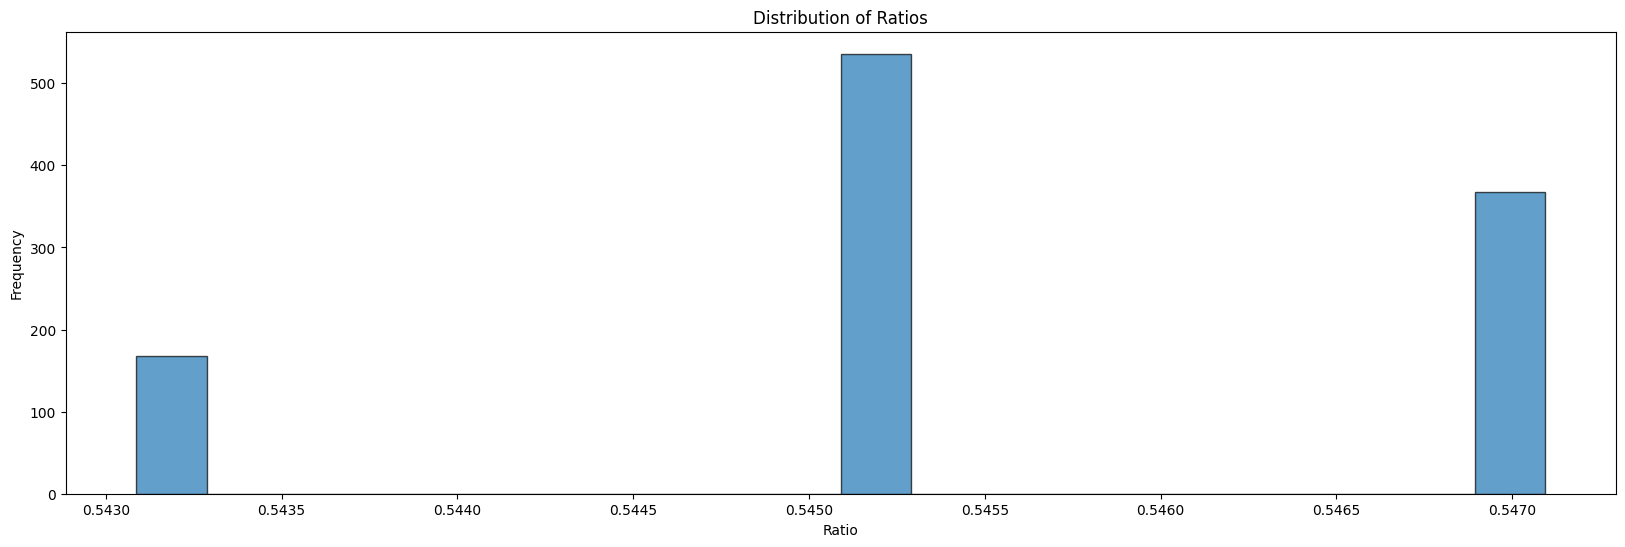

In [148]:
import matplotlib.pyplot as plt

# Plot the distribution of ratios as a histogram
plt.figure(figsize=(20, 6))
plt.hist(ratios_filtered, bins=20, edgecolor='k', alpha=0.7)
plt.title('Distribution of Ratios')
plt.xlabel('Ratio')
plt.ylabel('Frequency')
plt.show()


# 